# Stock Market Prediction using Multivariate Time Series

In [1]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2017-01-01'

stockname = 'Apple'
symbol = 'AAPL'

import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

df.head()

Tensorflow Version: 2.10.0
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,28.950001,29.082500,28.690001,29.037500,27.219835,115127600
2017-01-04 00:00:00-05:00,28.962500,29.127501,28.937500,29.004999,27.189371,84472400
2017-01-05 00:00:00-05:00,28.980000,29.215000,28.952499,29.152500,27.327633,88774400
2017-01-06 00:00:00-05:00,29.195000,29.540001,29.117500,29.477501,27.632292,127007600
2017-01-09 00:00:00-05:00,29.487499,29.857500,29.485001,29.747499,27.885389,134247600


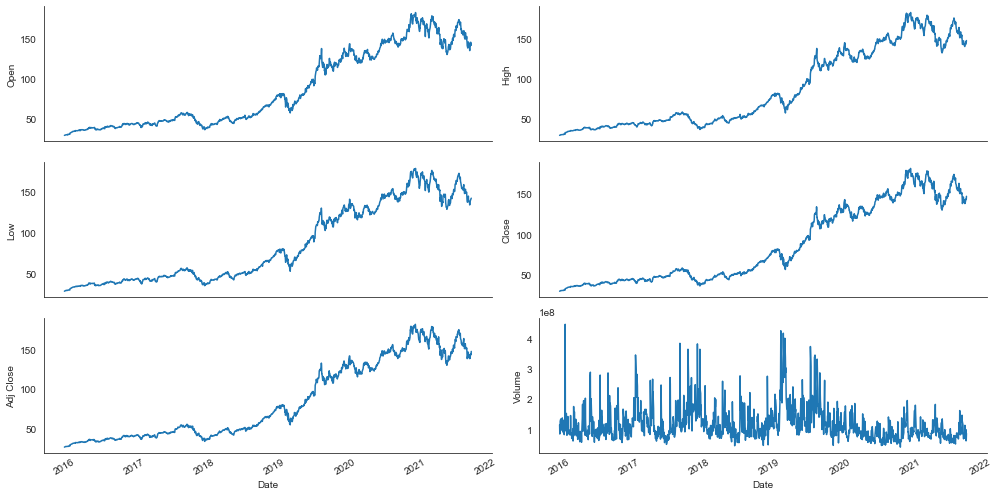

In [2]:
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [3]:
train_df = df.sort_values(by=['Date']).copy()

FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2022-10-17 00:00:00-04:00,142.899994,140.270004,141.070007,142.410004,85250900,142.410004
2022-10-18 00:00:00-04:00,146.699997,140.610001,145.490005,143.750000,99136600,143.750000
2022-10-19 00:00:00-04:00,144.949997,141.500000,141.690002,143.860001,61758300,143.860001
2022-10-20 00:00:00-04:00,145.889999,142.649994,143.020004,143.389999,64522000,143.389999
2022-10-21 00:00:00-04:00,147.850006,142.649994,142.869995,147.270004,86464700,147.270004


In [4]:
nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1462, 5)


In [5]:
sequence_length = 50

index_Close = data.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close]) 

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1120, 50, 5) (1120,)
(292, 50, 5) (292,)
0.040309150924355136
0.040309150924355136


In [6]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

250 50 5


In [7]:
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
    

Epoch 1/50
70/70 [==============================] - 11s 111ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 2/50
70/70 [==============================] - 7s 99ms/step - loss: 4.4650e-04 - val_loss: 0.0018
Epoch 3/50
70/70 [==============================] - 7s 102ms/step - loss: 3.4902e-04 - val_loss: 0.0060
Epoch 4/50
70/70 [==============================] - 8s 111ms/step - loss: 4.9780e-04 - val_loss: 0.0016
Epoch 5/50
70/70 [==============================] - 7s 99ms/step - loss: 3.3702e-04 - val_loss: 0.0015
Epoch 6/50
70/70 [==============================] - 7s 95ms/step - loss: 4.2279e-04 - val_loss: 0.0044
Epoch 7/50
70/70 [==============================] - 7s 102ms/step - loss: 6.8859e-04 - val_loss: 0.0024
Epoch 8/50
70/70 [==============================] - 7s 97ms/step - loss: 2.7627e-04 - val_loss: 9.9439e-04
Epoch 9/50
70/70 [==============================] - 7s 94ms/step - loss: 2.5903e-04 - val_loss: 0.0011
Epoch 10/50
70/70 [==============================] - 7s 93ms/step - 

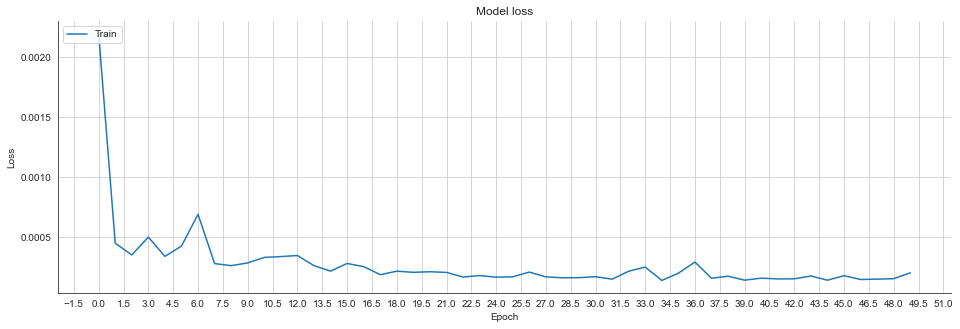

In [8]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [9]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

10/10 [==============================] - 1s 67ms/step
Median Absolute Error (MAE): 2.63
Mean Absolute Percentage Error (MAPE): 1.69 %
Median Absolute Percentage Error (MDAPE): 1.4 %


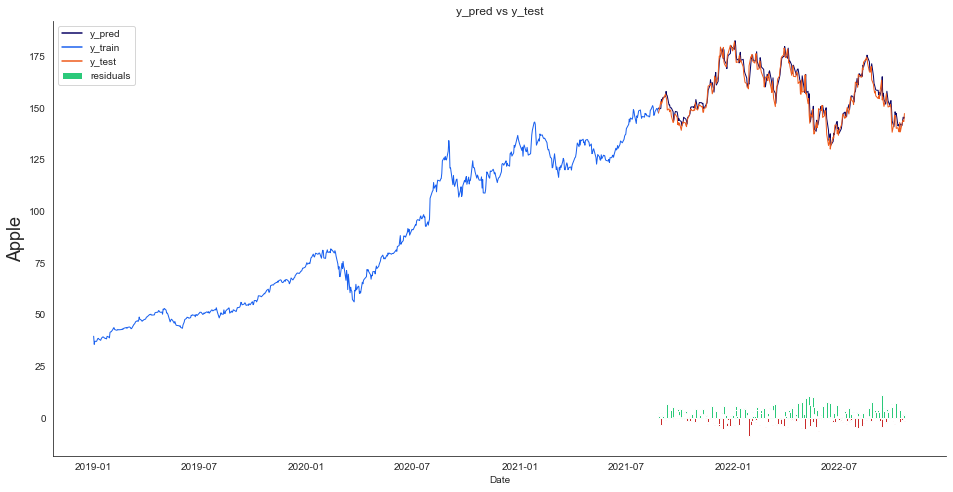

In [10]:
# The date from which on the date is displayed
display_start_date = "2019-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [11]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 28ms/step
The close price for Apple at 2022-10-24 was 147.27
The predicted close price is 147.80999755859375 (+0.37%)
